# Investment Model for Nasdaq-100 
-----
### 0. Project Introduction (Liao Wenhui)

### 1. Cluster NasDaq Stocks (Liao Wenhui)
* **[Hierarchical Clustering](#HC)** 

### 2. Stock Picking Modeld (Lyu Xiaomin)
* **[Model 1: CAMP](#CAPM)**
* **[Model 2: XGBoost](#XGB)**

### 3. Dynamic Weights Determination
* **[Model 1: Lasso Regression](#Lasso)** (Song Zhihui)
* **[Model 2: RNN Model](#RNN)** (Song Zhihui)
* **[Experiment 1: Dynamic Optimal Investment VS Random Investment VS Nasdaq-100](#Exp1)** (Guan Qianyun)
* **[Plot Cumulative Return & Change Rate of Portfolios](#pltCR1)** (Guan Qiayun)

### 4. Static Weights Determination
* **[Efficient Frontier Curve](#EFC)** (Wang Yijie)
* **[Experiment 2: Optimal Weights VS Random Weights VS Nasdaq-100](#Exp2)** (Guan Qiayun)
* **[Plot Cumulative Return & Change Rate of Portfolios](#pltCR2)** (Guan Qianyun)

### Addtional Workloads:
1. Project Data Collection -- Guan Qianyun
2. PPT Integration & Typesetting -- Wang Yijie
3. Prerecorded Video Integration & Processing -- Song Zhihui

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Activation
import statsmodels.api as sm
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from scipy.spatial.distance import cdist
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV
from sklearn.linear_model import Ridge,RidgeCV
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from tqdm import tqdm
import heapq


'''
Definations for the project
'''
# Define sigmoid function
def sigmoid(z):
    return 1/(1 + np.exp(-z))
# risk free rate (yearly: 2%)
rf = 2

## 0. Project Introduction

1. We aims to find out the model and method of the **optimal trading strategy** for the portfolio of 10 stocks traded on NASDAQ. 


2. In order to **diversify risks**, the idea of clustering was used to classify the stocks in the NASDAQ-100, and then **CAPM & machine learning methods** were applied to select a representative stock from each category to construct our 10-stock portfolio.


3. Finally, by combining **dynamic and static** weights determination methods in different periods, the weight of each stock is decided, which is eventually our trading strategy.


## Load Data

In [2]:
df = pd.read_csv('Nasdaq_data/nasdaq_stocks_102.csv') # Nasdaq 100 (102 stocks) daily change
df_nasdaq_100 = pd.read_csv('Nasdaq_data/nasdap100_daily.csv') # Nasdaq 100 daily change
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,symbol
0,2020-09-30,117.260002,113.620003,113.790001,115.809998,142675200.0,115.069893,AAPL
1,2020-10-01,117.720001,115.830002,117.639999,116.790001,116120400.0,116.043625,AAPL
2,2020-10-02,115.370003,112.220001,112.889999,113.019997,144712000.0,112.297722,AAPL
3,2020-10-05,116.650002,113.550003,113.910004,116.500000,106243800.0,115.755486,AAPL
4,2020-10-06,116.120003,112.250000,115.699997,113.160004,161498200.0,112.436836,AAPL


## Data Preprocess

### Add Change Rate Column
Change Rate = Adj Close - Adj Close (previous day)

In [3]:
# Add to 102 stocks
df_chg_table = pd.DataFrame([range(len(df.columns))], index=[-1])
df_chg_table.columns = df.columns
df['change_rate'] = [0.0 for i in range(len(df))]

for symbol, group in df.groupby('symbol'):
    pre_value = 0
    for index in range(len(group['Adj Close'])):
        if pre_value == 0: # first day
            value = group['Adj Close'].iloc[index]
            group['change_rate'].iloc[index] = 0 # change_pct = 0
            pre_value = value
        else:
            value = group['Adj Close'].iloc[index]
            group['change_rate'].iloc[index] = (value - pre_value) / pre_value
            pre_value = value
    df_chg_table = pd.concat([df_chg_table, group])
        
df_chg_table = df_chg_table.drop([-1])
df_chg_table.to_csv('Nasdaq_data/nasdaq_stocks_102_chg_pct.csv')
df = df_chg_table
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,symbol,change_rate
0,2020-09-30,117.260002,113.620003,113.790001,115.809998,142675200.0,115.069893,AAPL,0.000000
1,2020-10-01,117.720001,115.830002,117.639999,116.790001,116120400.0,116.043625,AAPL,0.008462
2,2020-10-02,115.370003,112.220001,112.889999,113.019997,144712000.0,112.297722,AAPL,-0.032280
3,2020-10-05,116.650002,113.550003,113.910004,116.500000,106243800.0,115.755486,AAPL,0.030791
4,2020-10-06,116.120003,112.250000,115.699997,113.160004,161498200.0,112.436836,AAPL,-0.028669


In [4]:
# Add to Nasdaq
df_nasdaq_100['change_rate'] = [0.0 for i in range(len(df_nasdaq_100))]

pre_value = 0
for index in range(len(df_nasdaq_100['Adj Close'])):
    if pre_value == 0: # first day
        value = df_nasdaq_100['Adj Close'].iloc[index]
        df_nasdaq_100['change_rate'].iloc[index] = 0 # change_pct = 0
        pre_value = value
    else:
        value = df_nasdaq_100['Adj Close'].iloc[index]
        df_nasdaq_100['change_rate'].iloc[index] = (value - pre_value) / pre_value
        pre_value = value
        
df_chg_table.to_csv('Nasdaq_data/nasdap100_daily_chg.csv')
df_nasdaq_100.head()

,Date,Open,High,Low,Close,Adj Close,Volume,change_rate
0,2020-09-30,11328.549805,11535.009766,11328.549805,11418.059570,11418.059570,4228200000,0.000000
1,2020-10-01,11554.959961,11606.730469,11488.599609,11583.200195,11583.200195,3978100000,0.014463
2,2020-10-02,11328.849609,11479.080078,11225.169922,11255.690430,11255.690430,3715090000,-0.028275
3,2020-10-05,11345.240234,11512.059570,11336.070313,11509.059570,11509.059570,3597940000,0.022510
4,2020-10-06,11476.679688,11536.419922,11256.259766,11291.269531,11291.269531,4360550000,-0.018923


### Change Date column index 

In [5]:
df.index = pd.to_datetime(df.Date)
df_nasdaq_100.index = pd.to_datetime(df_nasdaq_100.Date)
df = df.drop(['Date'], axis=1)
df_nasdaq_100 = df_nasdaq_100.drop(['Date'],axis=1)
df.head()

,High,Low,Open,Close,Volume,Adj Close,symbol,change_rate
Date,,,,,,,,
2020-09-30,117.260002,113.620003,113.790001,115.809998,142675200.0,115.069893,AAPL,0.000000
2020-10-01,117.720001,115.830002,117.639999,116.790001,116120400.0,116.043625,AAPL,0.008462
2020-10-02,115.370003,112.220001,112.889999,113.019997,144712000.0,112.297722,AAPL,-0.032280
2020-10-05,116.650002,113.550003,113.910004,116.500000,106243800.0,115.755486,AAPL,0.030791
2020-10-06,116.120003,112.250000,115.699997,113.160004,161498200.0,112.436836,AAPL,-0.028669


In [6]:
# Inspect data
df.isnull().sum()

High           0
Low            0
Open           0
Close          0
Volume         0
Adj Close      0
symbol         0
change_rate    0
dtype: int64

In [7]:
df_nasdaq_100.isnull().sum()

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
change_rate    0
dtype: int64

## 1. Cluster NasDaq Stocks

In [8]:
'''
Contruct X for cluster
'''
stocks = df.groupby('symbol')
lst_name = []
X = None
flag = True

for name, group in stocks:
    lst_name.append(name)
    if flag:
        X = np.array(group['change_rate'])
        flag = False
    else:
        X = np.row_stack((X, np.array(group['change_rate'])))     
print('X: ', X.shape)

X:  (102, 278)


### Hierarchical Clustering<a name='HC'></a>

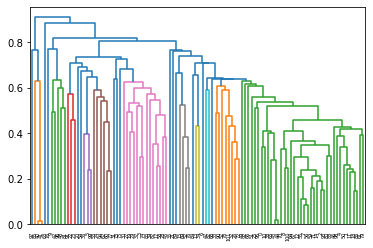

In [9]:
# Compute the similarity of the stocks by correlation distance
disMat = sch.distance.pdist(X,'correlation') # dis of each data points
Z_corr=sch.linkage(disMat,method='average') 
P=sch.dendrogram(Z_corr)

In [10]:
# Write Clustering Results
labels = sch.fcluster(Z_corr, 10, criterion='maxclust')
cluster_result = pd.DataFrame( {"stock_symbol": lst_name, "cls_num": list(labels)})
cluster_result.to_csv('Nasdaq_data/clustering_result.csv')
cluster_result

,stock_symbol,cls_num
0,AAPL,7
1,ADBE,7
2,ADI,7
3,ADP,5
4,ADSK,7
...,...,...
97,WBA,2
98,WDAY,7
99,XEL,5
100,XLNX,7


In [11]:
# Show cluster count
cluster_result['cls_num'].value_counts()

7     53
5     31
3      5
6      5
1      3
4      1
8      1
9      1
10     1
2      1
Name: cls_num, dtype: int64

## 2. Stock Picking Model

### Data Preprocess for Stock Picking Model

In [12]:
# Load stocks of all classes
results = cluster_result.groupby('cls_num')
cluster_lst = []
for cls_num, group in results:
    temp = []
    temp.append(list(group['stock_symbol']))
    cluster_lst.append(temp)
    
# Save all stock names
stock_name_lst = []
for i in range(10):
    stock_name_lst.append(cluster_lst[i][0])
    print('Class '+ str(i + 1) + ': '+ str(cluster_lst[i][0]) )

Class 1: ['FOX', 'FOXA', 'SIRI']
Class 2: ['WBA']
Class 3: ['AMGN', 'GILD', 'INCY', 'REGN', 'VRTX']
Class 4: ['BIIB']
Class 5: ['ADP', 'AEP', 'BKNG', 'CDW', 'CERN', 'CHTR', 'CMCSA', 'COST', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'DLTR', 'EXC', 'FAST', 'FISV', 'HON', 'KDP', 'KHC', 'MAR', 'MDLZ', 'MNST', 'ORLY', 'PAYX', 'PCAR', 'PEP', 'ROST', 'SBUX', 'TMUS', 'VRSK', 'XEL']
Class 6: ['BIDU', 'JD', 'NTES', 'PDD', 'TCOM']
Class 7: ['AAPL', 'ADBE', 'ADI', 'ADSK', 'ALGN', 'AMAT', 'AMD', 'AMZN', 'ANSS', 'ASML', 'ATVI', 'AVGO', 'CDNS', 'CPRT', 'CRWD', 'DOCU', 'DXCM', 'EA', 'FB', 'GOOG', 'GOOGL', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KLAC', 'LRCX', 'LULU', 'MCHP', 'MELI', 'MRVL', 'MSFT', 'MTCH', 'MU', 'NFLX', 'NVDA', 'NXPI', 'OKTA', 'PTON', 'PYPL', 'QCOM', 'SGEN', 'SNPS', 'SPLK', 'SWKS', 'TEAM', 'TSLA', 'TXN', 'VRSN', 'WDAY', 'XLNX', 'ZM']
Class 8: ['CHKP']
Class 9: ['EBAY']
Class 10: ['MRNA']


### Model 1: CAMP<a name='CAPM'></a>

In [13]:
'''
Choose Stocks from Cluster Results

* Regression Model： (Ri - Rf) = Bi(Rm - Rf) + α
* (Ri - Rf): risk premium for each stock
* (Rm - Rf): market risk premium（market -> Nasdaq-100）

'''
# Construct change_rate table
df_lst = []
for cls_num in range(10):
    df_new = df_nasdaq_100['change_rate']
    for sym in stock_name_lst[cls_num]: 
        tmp = df[df['symbol'] == sym]
        df_new = pd.concat([df_new, tmp['change_rate']], axis=1)
    df_new.columns =  ['NASDAQ_100'] + stock_name_lst[cls_num]
    df_lst.append(df_new)

# CAMP : Choose best alpha
optimal_stock_names = [] # Find Optimal Stocks
all_alpha_lst = []
all_scale_lst = []
all_scores_lst = []

for cls in range(10):
    alpha_lst = []
    scale_lst = []
    scores_lst = []
    
    # Only one stock, skip picking process
    if len(df_lst[cls].columns) == 2:
        all_alpha_lst.append([])
        all_scale_lst.append([])
        optimal_stock_names.append(df_lst[cls].columns[-1])
        continue
    else: 
        lst_syms = list(df_lst[cls].columns)
        lst_syms.pop(0)
        for stock in lst_syms:
            model = sm.OLS(df_lst[cls][stock], sm.add_constant(df_lst[cls]['NASDAQ_100']))
            result = model.fit()
            # print(result.summary())
            alpha_lst.append(result.params[0])
            scale_lst.append(result.rsquared_adj)
            '''
            Score Function (for CAMP)
            '''
            score = result.rsquared_adj * result.params[0] / np.abs(result.params[1])
            scores_lst.append(score)
            
        optimal_stock_names.append(lst_syms[scores_lst.index(max(scores_lst))])
        all_alpha_lst.append(alpha_lst)
        all_scale_lst.append(scale_lst)
        
optimal_stock_names

# ['FOX', 'TCOM', 'GILD', 'SGEN', 'COST', 'PAYX', 'GOOG', 'EBAY', 'MRNA', 'BIIB']

['SIRI', 'WBA', 'GILD', 'BIIB', 'COST', 'BIDU', 'GOOG', 'CHKP', 'EBAY', 'MRNA']

In [14]:
'''
Choose from No Cluster Results (102 stocks) 
'''
df_no_cluster = df_nasdaq_100['change_rate']
name_lst = list(cluster_result['stock_symbol'].values)

for sym in name_lst: 
        tmp = df[df['symbol'] == sym]
        df_no_cluster = pd.concat([df_no_cluster, tmp['change_rate']], axis=1)
df_no_cluster.columns = ['NASDAQ_100'] + name_lst

# CAMP
lst_syms = list(df_no_cluster.columns)
lst_syms.pop(0) # delete Nasdaq 

alpha_lst = []
beta_lst = []
rsquare_lst = []
scores_lst = []

for stock in lst_syms:
    x = sm.add_constant(df_no_cluster['NASDAQ_100']) # Add const
    y = df_no_cluster[stock]
    model = sm.OLS(y,x) 
    result = model.fit()
    # Save Params
    alpha_lst.append(result.params[0])
    beta_lst.append(result.params[1])
    rsquare_lst.append(result.rsquared_adj)
    '''
    Score Function (for CAMP)
    '''
    score = result.rsquared_adj * result.params[0] / np.abs(result.params[1])
    scores_lst.append(score)

no_cluster_names = []
max_index_list = map(scores_lst.index, heapq.nlargest(10, scores_lst))
for index in max_index_list:
    no_cluster_names.append(lst_syms[index])
    
no_cluster_names

['GOOG',
 'GOOGL',
 'INTU',
 'ASML',
 'COST',
 'AMAT',
 'PAYX',
 'TSLA',
 'TEAM',
 'CSCO']

### Model 2: XGBoost<a name='XGB'></a>

In [15]:
## Result From Outside file
import time
import xgboost as xgb

data = []
for code in df.symbol.unique():
    df_temp = df[df.symbol == code].copy()
    df_temp['return'] = np.append(np.log(df_temp['Adj Close']).diff(30)[30:],np.zeros(30))
#     df_temp = df_temp.iloc[:-30]
    data.append(df_temp)
data = pd.concat(data)
data_train = data[data.Date <= '2021-07-31'].copy()

def sliding_windows(x,y, seq_length = 20):
    res_x = []
    res_y = []
    for i in range(x.shape[0]-seq_length):        
        _x = np.array(x.iloc[i:(i+seq_length)])
        _y = np.array(y.iloc[i+seq_length])
        res_x.append(_x)
        res_y.append(_y)    
    return np.array(res_x),np.array(res_y)

def gen_whole(data):
    data_train_x = np.array([])
    data_train_y = np.array([])    
    for code in data.symbol.unique():
        data_temp = data[data.symbol == code].copy()
        x,y = sliding_windows(data_temp[['High', 'Low', 'Open', 'Close']], data_temp['return'])
        data_train_x = np.append(x, data_train_x)
        data_train_y = np.append(y, data_train_y)
    return data_train_x.reshape(-1, 80),data_train_y.reshape(-1, 1)

def customedscore(preds, dtrain):
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    label = dtrain.get_label()
    print(spearmanr(preds,label))
    print(kendalltau(preds,label))
    return 'Pearsonr',pearsonr(preds,label)[0]

# Get Train Data
x_train, y_train = gen_whole(data_train)
print(x_train.shape, y_train.shape)

# Get Val Data
data_val = data[(data.Date >= '2021-06-30') & (data.Date <= '2021-09-30')].copy()
x_val, y_val = gen_whole(data_val)
print(x_val.shape, y_val.shape)

# Get Test Data
data_test = data[(data.Date >= '2021-08-30')].copy()
x_test, y_test = gen_whole(data_test)
print(x_test.shape, y_test.shape)

# Train Preparation
s = time.time()
num_round = 100 #3000
param = {'objective': 'reg:linear', 
         'max_depth':5,
#           'n_estimators':500,
         'tree_method': 'hist', # Use CPU accelerated algorithm
         'subsample':1,
#          'feval' : customedscore
         'eval_metric':['rmse','mae'],
         'eta':0.2
         }
# Leave most parameters as default
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_val, label=y_val)
dtest = xgb.DMatrix(x_test, label=y_test)
print(time.time()-s)

# Train Model
xgb_model = xgb.train(param, dtrain, num_round, evals=[(dval, 'val')], feval = customedscore)
xgb_model.save_model('NASDAQ.model')

# Test Period
def sliding_windows2(x, seq_length = 20):
    df = []
    for i in range(x.shape[0]-seq_length):
        df.append(pd.DataFrame(x.iloc[i+seq_length]).T)
    return pd.concat(df)
def gen_whole2(data):
    df = []
    for code in data.symbol.unique():
        data_temp = data[data.symbol == code].copy()
        df_temp = sliding_windows2(data_temp)
        df.append(df_temp)
    return pd.concat(df)

data_train2 = data[data.Date <= '2021-07-31'].copy()
data_train2 = gen_whole2(data_train2)
data_val2 = data[(data.Date >= '2021-06-30') & (data.Date <= '2021-09-30')].copy()
data_val2 = gen_whole2(data_val2)
data_test2 = data[(data.Date >= '2021-08-30') ].copy()
data_test2 = gen_whole2(data_test2)

model_name = 'NASDAQ.model'
bst = xgb.Booster()
bst.load_model(model_name)
pred_train = bst.predict(dtrain)
pred_val = bst.predict(dval)
pred_test = bst.predict(dtest)
data_train2['preds'] = pred_train
data_val2['preds'] = pred_val
data_test2['preds'] = pred_test

# Show final Result
date = '2021-10-01'
res = data_test2[data_test2.Date == date]
res.sort_values('preds', ascending=False)[['symbol','return','preds']].iloc[:10]

AttributeError: 'DataFrame' object has no attribute 'Date'

## Choose Stock Names ( Cluster+CAPM / CAPM / XGBoost )

In [15]:
'''
Choose 10 stocks for following experiment:

1. no_cluster_names: Only use CAPM to pick 10 stocks from Nasdaq-100;
2. optimal_stock_names: Perform hierarchical clustering, then use CAPM pick one optimal stock from each cluster;
3. xgboost_names: Only use XGBoost to pick 10 stocks from Nasdaq-100;

'''
xgboost_names = ['MRNA', 'XEL', 'BKNG', 'HON', 'MELI', 'JD', 'KHC', 'DXCM', 'REGN', 'AMAT']

# name_lst = no_cluster_names # no cluster result
name_lst = optimal_stock_names # cluster result
# name_lst = xgboost_names # XGBoost result

## 3. Dynamic Weights Determination

### Model 1: Lasso Regression<a name='Lasso'></a>

In [29]:
'''
Construct Lasso Models for Each stock
'''
# Load Dataset
datasets = []
for name in name_lst:
    df_choose = df[df['symbol'] == name]
    dataset = df_choose['Adj Close'].values
    datasets.append(dataset)
datasets = np.array(datasets)

# MinMax Transform
# sc = MinMaxScaler(feature_range=(0, 1)) 
# datasets = sc.fit_transform(datasets)
    
lasso_models = []
val_x_lst = []
val_y_lst = []
test_x_lst = []
test_y_lst = []

for dataset in datasets:
    # Train / Val / Test split
    train_set = dataset[0:195] # 2020-09-30 to 2020-07-31
    val_set_1 = dataset[195:224] # M8-M9
    val_set_2 = dataset[224:253]
    test_set = dataset[253:] # M10

    # Contruct X and y
    x_train = []
    y_train = []
    x_val_1 = []
    y_val_1 = []
    x_val_2 = []
    y_val_2 = []
    x_test = []
    y_test = []
    steps = 15

    # Change data forms
    for i in range(steps, len(train_set)):
        x_train.append(train_set[i - steps:i])
        y_train.append(train_set[i])
    for i in range(steps, len(val_set)):
        x_val.append(val_set[i - steps:i])
        y_val.append(val_set[i])
    for i in range(steps, len(test_set)):
        x_test.append(test_set[i - steps:i])
        y_test.append(test_set[i])

    # Train Model
    x_train = np.array(x_train).squeeze()
    x_test = np.array(x_test).squeeze()
    lasso = Lasso(alpha = 0.0001).fit(x_train, y_train)
    
    val_x_lst.append(x_val)
    val_y_lst.append(y_val)
    test_x_lst.append(x_test)
    test_y_lst.append(y_test)
    lasso_models.append(lasso)
    
print('Val Working Days: ', len(val_set) - 15)
print('Lasso Models : ', len(lasso_models))

NameError: name 'val_set' is not defined

### Model 2:  RNN Model<a name='RNN'></a>

In [65]:
'''
Construct RNN Models for Each stock

'''
rnn_models = []
val_x_lst_M8 = []
val_y_lst_M8 = []
val_x_lst_M9 = []
val_y_lst_M9 = []

test_x_lst = []
test_y_lst = []
n = 1

for dataset in datasets:
   # Train / Val / Test split
    train_set = dataset[0:195] # 2020-09-30 to 2020-07-31
    val_set_1 = dataset[195:232] # M8-M9
    val_set_2 = dataset[217:253] 
    test_set = dataset[253:] # M10

    # Contruct X and y
    x_train = []
    y_train = []
    
    x_val_1 = []
    y_val_1 = []
    x_val_2 = []
    y_val_2 = []
    
    x_test = []
    y_test = []
    steps = 15

    # Change data forms
    for i in range(steps, len(train_set)):
        x_train.append(train_set[i - steps:i])
        y_train.append(train_set[i])
        
    for i in range(steps, len(val_set_1)):
        x_val_1.append(val_set_1[i - steps:i])
        y_val_1.append(val_set_1[i])
        
    for i in range(steps, len(val_set_2)):
        x_val_2.append(val_set_2[i - steps:i])
        y_val_2.append(val_set_2[i])
        
    for i in range(steps, len(test_set)):
        x_test.append(test_set[i - steps:i])
        y_test.append(test_set[i])
        
    # make data fit with RNN [Sample Num, Steps, Feature Num]
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], steps, 1))
    
    x_val_1, y_val_1 = np.array(x_val_1), np.array(y_val_1)
    x_val_1 = np.reshape(x_val_1, (x_val_1.shape[0], steps, 1))
    
    x_val_2, y_val_2 = np.array(x_val_2), np.array(y_val_2)
    x_val_2 = np.reshape(x_val_2, (x_val_2.shape[0], steps, 1))
    
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0], steps, 1))

    # Train Model
    # Construct RNN
    print('Model ' + str(n) + ': ')
    model = tf.keras.Sequential([
        SimpleRNN(100, return_sequences=True),
        Dropout(0.2),
        SimpleRNN(100),
        Dense(1)
    ])
    print(y_train.shape)
    print(y_val_1.shape)
    
    all_x = np.vstack((x_train, x_val_1))
    all_y = np.vstack((y_train.reshape(-1, 1), y_val_1.reshape(-1, 1)))
    print('------')
    print(all_x.shape)
    print(all_y.shape)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')  # 损失函数用均方误差
    model.fit(all_x, all_x, batch_size=32, epochs=50, validation_split=0.1, validation_freq=1)
    
    # Save models
    # if os.path.exists('./model_weights/model' + str(n) + '.h5'):
    #    print("Load Model ", n)
    #    model = load_model('./model_weights/model' + str(n) + '.h5')
    # else:
    #    print("Train Model ", n)
    #    model.fit(x_train, y_train, batch_size=32, epochs=50, validation_split=0.15, validation_freq=1)
    #    model.save('./model_weights/model' + str(n) + '.h5')
    
    val_x_lst_M8.append(x_val_1)
    val_y_lst_M8.append(y_val_1)
    
    val_x_lst_M9.append(x_val_2)
    val_y_lst_M9.append(y_val_2)
    
    test_x_lst.append(x_test)
    test_y_lst.append(y_test)
    rnn_models.append(model)
    n += 1
    
print('RNN Models : ', len(rnn_models))


Model 1: 
(180,)
(22,)
------
(202, 15, 1)
(202, 1)
Epoch 1/50
6/6 [==============================] - 1s 25ms/step - loss: 12.1257 - val_loss: 0.2222
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 0.5316 - val_loss: 0.9615
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 0.7930 - val_loss: 0.0864
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 0.1499 - val_loss: 0.1892
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 0.1716 - val_loss: 0.2047
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 0.1368 - val_loss: 0.0487
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0986 - val_loss: 0.0312
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 0.1117 - val_loss: 0.0358
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0822 - val_loss: 0.0697
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0861 - va

6/6 [==============================] - 0s 6ms/step - loss: 378.2321 - val_loss: 352.0723
Epoch 34/50
6/6 [==============================] - 0s 6ms/step - loss: 362.4529 - val_loss: 336.1137
Epoch 35/50
6/6 [==============================] - 0s 6ms/step - loss: 347.3754 - val_loss: 320.7159
Epoch 36/50
6/6 [==============================] - 0s 6ms/step - loss: 333.0722 - val_loss: 305.8196
Epoch 37/50
6/6 [==============================] - 0s 6ms/step - loss: 318.8555 - val_loss: 291.6737
Epoch 38/50
6/6 [==============================] - 0s 6ms/step - loss: 305.5309 - val_loss: 278.0477
Epoch 39/50
6/6 [==============================] - 0s 6ms/step - loss: 292.7389 - val_loss: 264.9327
Epoch 40/50
6/6 [==============================] - 0s 6ms/step - loss: 280.4520 - val_loss: 252.2821
Epoch 41/50
6/6 [==============================] - 0s 6ms/step - loss: 268.4866 - val_loss: 240.1954
Epoch 42/50
6/6 [==============================] - 0s 6ms/step - loss: 257.2621 - val_loss: 228.5480
Ep

Epoch 12/50
6/6 [==============================] - 0s 7ms/step - loss: 68247.4219 - val_loss: 101221.7031
Epoch 13/50
6/6 [==============================] - 0s 7ms/step - loss: 67916.7188 - val_loss: 100813.8438
Epoch 14/50
6/6 [==============================] - 0s 7ms/step - loss: 67587.6016 - val_loss: 100409.5703
Epoch 15/50
6/6 [==============================] - 0s 6ms/step - loss: 67259.2734 - val_loss: 100009.7109
Epoch 16/50
6/6 [==============================] - 0s 6ms/step - loss: 66936.3672 - val_loss: 99611.7109
Epoch 17/50
6/6 [==============================] - 0s 7ms/step - loss: 66614.2266 - val_loss: 99216.8359
Epoch 18/50
6/6 [==============================] - 0s 7ms/step - loss: 66295.4375 - val_loss: 98824.2344
Epoch 19/50
6/6 [==============================] - 0s 7ms/step - loss: 65976.8594 - val_loss: 98434.7734
Epoch 20/50
6/6 [==============================] - 0s 7ms/step - loss: 65664.0547 - val_loss: 98045.7344
Epoch 21/50
6/6 [==============================] - 

Epoch 39/50
6/6 [==============================] - 0s 6ms/step - loss: 109153.3516 - val_loss: 161977.9688
Epoch 40/50
6/6 [==============================] - 0s 6ms/step - loss: 108760.5078 - val_loss: 161497.3750
Epoch 41/50
6/6 [==============================] - 0s 6ms/step - loss: 108366.8594 - val_loss: 161018.7500
Epoch 42/50
6/6 [==============================] - 0s 6ms/step - loss: 107975.4688 - val_loss: 160541.5312
Epoch 43/50
6/6 [==============================] - 0s 6ms/step - loss: 107585.0703 - val_loss: 160065.7344
Epoch 44/50
6/6 [==============================] - 0s 6ms/step - loss: 107195.3672 - val_loss: 159591.4688
Epoch 45/50
6/6 [==============================] - 0s 6ms/step - loss: 106808.3750 - val_loss: 159117.6406
Epoch 46/50
6/6 [==============================] - 0s 6ms/step - loss: 106422.1016 - val_loss: 158645.1250
Epoch 47/50
6/6 [==============================] - 0s 6ms/step - loss: 106035.1250 - val_loss: 158174.5312
Epoch 48/50
6/6 [====================

6/6 [==============================] - 0s 7ms/step - loss: 7311.6899 - val_loss: 7939.1646
Epoch 42/50
6/6 [==============================] - 0s 7ms/step - loss: 7218.2480 - val_loss: 7841.9614
Epoch 43/50
6/6 [==============================] - 0s 7ms/step - loss: 7125.9751 - val_loss: 7745.6650
Epoch 44/50
6/6 [==============================] - 0s 7ms/step - loss: 7034.2969 - val_loss: 7650.4351
Epoch 45/50
6/6 [==============================] - 0s 7ms/step - loss: 6944.0850 - val_loss: 7555.9502
Epoch 46/50
6/6 [==============================] - 0s 7ms/step - loss: 6853.9897 - val_loss: 7462.5327
Epoch 47/50
6/6 [==============================] - 0s 7ms/step - loss: 6765.4717 - val_loss: 7369.8726
Epoch 48/50
6/6 [==============================] - 0s 7ms/step - loss: 6677.6064 - val_loss: 7278.1978
Epoch 49/50
6/6 [==============================] - 0s 7ms/step - loss: 6590.8281 - val_loss: 7187.3667
Epoch 50/50
6/6 [==============================] - 0s 7ms/step - loss: 6504.6333 - va

### Experiment: Dynamic Optimal Investment VS Random Investment VS Nasdaq-100 <a name='Exp1'></a>

In [39]:
'''
Tool Functions
'''
# Set random weight
def random_weight(dim):
    weight=np.random.uniform(1,100,size=dim)
    a_sum = np.sum(weight)
    for i in range(0,len(weight)):
        weight[i] /= a_sum
    return weight  

def Simulate_dynamic_investment(random_flag, x_lst, y_lst, model_lst, model_type='lasso', output=True):
    '''
    Params Definations:
    
    random_flag: 1(random weights)
    beta: Model prediction Sensitivity (>0)
    x_lst / y_lst: Test data list (for every model)
    model_lst: prediction models list
    model_type: 'lasso', 'rnn'
    days: simulation days
    
    '''
    final = 1 
    stock_weights = [0 for i in range(len(model_lst))]
    all_chg_rate = []
    
    for day in range(len(y_lst[0])): # 30 days
        # Initialize paras
        price_chg_lst = []
        real_chg_lst = []
        p = 0 # model pointer
          
        # Upate stock weights, according to each model's prediction
        for model in model_lst:
            # Get Predicted Data
            if model_type == 'lasso':
                predicted_stock_price = model.predict(x_lst[p][day].reshape(1, -1))
            elif model_type == 'rnn':
                predicted_stock_price = model.predict(x_lst[p][day].reshape(1, len(x_lst[p][day]), 1))
            else:
                raise(NameError("No model type called: ", model_type))
                
            # Retore Predicted Data
            # predicted_stock_price = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))[0][0]
            # real_stock_price = sc.inverse_transform(y_lst[p][day].reshape(-1, 1))[0][0]
            # pre_price = sc.inverse_transform(x_lst[p][day][-1].reshape(-1, 1))[0][0]
            real_stock_price = y_lst[p][day]
            pre_price = x_lst[p][day][-1]
                
            # Calculate change rate
            change = (predicted_stock_price - pre_price) / pre_price # change percent
            real_change = (real_stock_price - pre_price) / pre_price   
            # save change pct
            price_chg_lst.append(change) 
            real_chg_lst.append(real_change)

            '''
            This is the CORE part for params updating.
            '''
            # update weights
            stock_weights[p] = sigmoid(1 * change) / np.log(std_vec[p])
            p += 1
        
        # make all weights add up to 1
        sum_weights = np.sum(stock_weights)
        for i in range(len(stock_weights)):
            stock_weights[i] /= sum_weights
        # if random weights
        if random_flag:
            stock_weights = random_weight(len(model_lst))
        # caculate real change pct
        R_r = 0
        for j in range(len(real_chg_lst)):
            R_r += real_chg_lst[j] * stock_weights[j]
        final *= (1 + R_r)
        all_chg_rate.append(R_r)
    
    return_rate = (final - 1) * 100
    R_mean = np.mean(all_chg_rate)
    
    if not random_flag:
        return_rate = return_rate[0]
    if model_type == 'rnn':
        return_rate = return_rate[0]
        
    '''
    Score Function (for portfolios)
    '''
    score = sigmoid((np.mean(all_chg_rate) - (1 + rf / 100) ** (1/360) + 1)) / np.std(all_chg_rate)
    if output:
        # print(all_chg_rate)
        print('Days: ', len(x_lst[0]))
        print('Period Return(%): ', return_rate)
        print('Expected Annual Return(%): ', ((1 + R_mean)**242 - 1) * 100)
        print('Expected Annual Vola(%): ', (1 + np.std(all_chg_rate))**242 - 1 )
        print('Score: ', score)
        print('-------------------------------')
    return return_rate , score, all_chg_rate

# Trading days
days_per_year = 252
# Construct change table
flag = True
for sym in name_lst: 
    tmp = df[df['symbol'] == sym]
    if flag:
        df_new = tmp['change_rate']
        flag = False
        continue
    df_new = pd.concat([df_new, tmp['change_rate']], axis=1)

df_new.columns = name_lst
std_vec = (1 + df_new.std()) ** days_per_year - 1
std_vec

SIRI        85.859464
WBA        171.302096
GILD        20.261127
BIIB     39812.323565
COST        15.168333
BIDU      5855.455002
GOOG        50.405748
CHKP        37.444217
EBAY       248.061831
MRNA    206518.438218
dtype: float64

In [66]:
'''
Optimal Investment (Lasso)

* Score Function (for portfolios):
* Score = sigmoid((np.mean(all_chg_rate) - 1.02 ** (1/360) + 1)) / np.std(all_chg_rate)
'''
return_rate, sharp_ratio, all_chg_rate_lasso = Simulate_dynamic_investment(0, val_x_lst, val_y_lst, lasso_models) 


IndexError: list index out of range

In [67]:
'''
Optimal Investment (RNN)
'''
return_rate, sharp_ratio, all_chg_rate_rnn= Simulate_dynamic_investment(0, val_x_lst_M9, val_y_lst_M9, rnn_models, model_type='rnn')


Days:  21
Period Return(%):  -5.353545877807542
Expected Annual Return(%):  -46.575160672850465
Expected Annual Vola(%):  5.363252538103959
Score:  65.05060091323455
-------------------------------


In [24]:
'''
Random Weights Investment
'''
times = 200 # Stimulation Times
return_rate_lst = []
sharp_ratio_lst = []

for i in tqdm(range(times)):
    return_ratio, sharp_ratio, all_chg_rate_ra= Simulate_dynamic_investment(1, val_x_lst, val_y_lst, lasso_models, output=False) # beta = 100
    return_rate_lst.append(return_ratio)
    sharp_ratio_lst.append(sharp_ratio)

print('Days: ', len(val_x_lst[0]))
print('Return Rate(%%): %f (%f)' %(np.mean(return_rate_lst), np.std(return_rate_lst)))
print('Score: %f (%f)' %(np.mean(sharp_ratio_lst), np.std(sharp_ratio_lst)))


100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 79.15it/s]

Days:  43
Return Rate(%): -0.259211 (2.430544)
Score: 53.803976 (4.185274)


In [25]:
'''
Nasdaq-100 Investment
'''
test_nasdaq = df_nasdaq_100['change_rate'][210:253]
Capital = 1
nasdaq_variations = [ ]

for i in range(len(test_nasdaq)):
    R_r = test_nasdaq.iloc[i]
    nasdaq_variations.append(R_r)
    Capital *= (1 + R_r)

optimal_sr = sigmoid((np.mean(nasdaq_variations) - (1 + rf / 100)**(1/360) + 1)) / np.std([i for i in nasdaq_variations])
optimal_cap = (Capital - 1) * 100

print('Days: ', len(test_nasdaq))
print('Nasdaq-100 Return(%): ' + str(round(optimal_cap, 3)))
print('Score: ', round(optimal_sr, 3))

Days:  43
Nasdaq-100 Return(%): -1.807
Score:  61.898


### Plot Cumulative Return & Change Rate of Portfolios <a name='pltCR1'> </a>

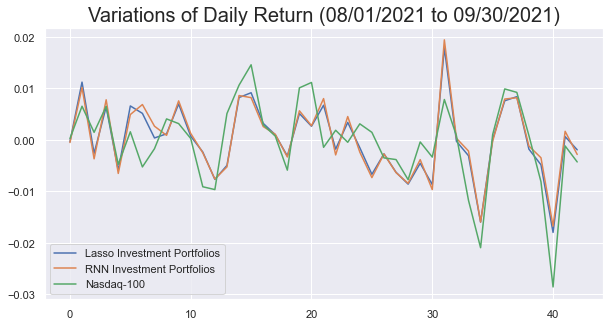

In [26]:
# Check the volatility of yield
df_portfolios = pd.DataFrame({
    'Lasso Investment Portfolios': all_chg_rate_lasso,
    'RNN Investment Portfolios': all_chg_rate_rnn,
    'Nasdaq-100': nasdaq_variations,
    # 'Random Investment Portfolios': all_chg_rate_ra,
})


sns.set()
plt.figure(figsize=(10, 5))
for col in df_portfolios.columns:
    plt.plot(df_portfolios[col], label=col)
plt.title('Variations of Daily Return (08/01/2021 to 09/30/2021)', fontsize=20)
plt.legend()

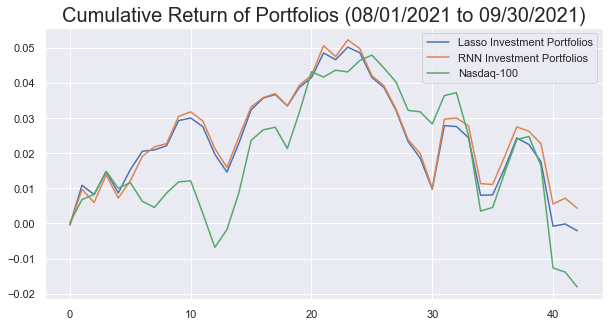

In [27]:
# print(len(all_chg_rate_rnn))
# Plot Time series of cumulative return

plt.figure(figsize=(10, 5))
for col in df_portfolios.columns:
    plt.plot((df_portfolios[col]+1).cumprod()-1, label=col)
    
plt.title('Cumulative Return of Portfolios (08/01/2021 to 09/30/2021)', fontsize=20)
plt.legend();

## 4. Static Weights Determination

### Data Preprocess

In [16]:
# Trading days
days_per_year = 252
# Construct change table
flag = True
for sym in name_lst: 
    tmp = df[df['symbol'] == sym]
    if flag:
        df_new = tmp['change_rate']
        flag = False
        continue
    df_new = pd.concat([df_new, tmp['change_rate']], axis=1)

df_new.columns = name_lst
# split test data
test_data = df_new[253:-4]
df_new = df_new[:253]
test_data

,SIRI,WBA,GILD,BIIB,COST,BIDU,GOOG,CHKP,EBAY,MRNA
Date,,,,,,,,,,
2021-10-01,0.003279,-0.005313,-0.018468,0.003357,-0.002270,-0.014114,0.023990,0.008050,0.003445,-0.113730
2021-10-04,0.000000,-0.002350,-0.014586,-0.019793,-0.018268,-0.034239,-0.019767,-0.002808,-0.020598,-0.044710
2021-10-05,0.009804,0.008567,-0.002368,0.007617,0.013859,0.023294,0.018032,0.000528,0.021907,0.019243
2021-10-06,-0.001618,-0.003822,0.001187,0.011090,0.006947,-0.002937,0.008643,0.009060,0.022438,-0.089398
2021-10-07,0.019449,0.020038,0.009781,0.014883,0.007856,0.048139,0.013334,0.017870,0.036763,0.022948
2021-10-08,-0.036566,-0.009822,-0.001321,-0.006742,-0.002252,0.035388,0.006254,0.000343,0.011865,-0.014384
2021-10-11,-0.016502,0.000844,0.000441,-0.000840,-0.004758,0.000432,-0.008629,0.017978,-0.007328,0.000623
2021-10-12,0.013423,0.000000,-0.010429,-0.002801,-0.006293,-0.016589,-0.015373,0.006728,0.002282,0.019764
2021-10-13,-0.006623,-0.003374,0.003859,-0.004003,-0.003513,0.027466,0.008682,0.010442,0.003080,0.033330


In [17]:
'''
Tool Functions
'''
# Set random weight
def random_weights(num,stock_list):
    weight=np.random.uniform(1,100,size=[num,len(stock_list)])
    for i in range(0,num):
        a_sum=0.0
        for j in range(0,len(stock_list)):
            a_sum+=weight[i][j]
        for k in range(0,len(stock_list)):
            weight[i][k]=round(float(weight[i][k]/a_sum),4)
    return weight  

# Calculate porfolio return
def portfolio_return(weight,mean,num,stock_list):
    portfolio_re=np.random.uniform(0,0,size=num)
    for i in range(0,num):
        for j in range(0,len(stock_list)):
            portfolio_re[i]=portfolio_re[i]+weight[i][j]*mean[j]
    return portfolio_re 

# Calculate porfolio standard deviation
def portfolio_standard_deviation(weight,cov_matrix,num,stock_list):
    portfolio_std=np.random.uniform(0,0,size=num)
    for i in range(0,num):
        # var=np.dot(weight[i],cov_matrix)
        # var=np.dot(var,weight[i].T) #combination variance
        # portfolio_std[i]=np.sqrt(var)
        portfolio_std[i] = np.dot(std_vector, weight[i].T)
    return portfolio_std

# Find optimal points (min std / max return / max sharp ratio)
def max_return_portfolio(p_return):
    p_return_list = list(p_return)
    p_return_max = max(p_return_list)
    p_return_max_index = p_return_list.index(p_return_max)
    return p_return_max_index, p_return_max
def min_std_portfolio(p_std):
    p_std_list = list(p_std)
    p_std_min = min(p_std_list)
    p_std_min_index = p_std_list.index(p_std_min)
    return p_std_min_index, p_std_min
def compute_sharp_ratio(returns,std,risk_free_r):
    sharp_ratio=np.random.uniform(0,0,size=len(returns))
    for i in range(0,len(sharp_ratio)):
        sharp_ratio[i]=(returns[i]-risk_free_r)/std[i]
    sharp_ratio_list = list(sharp_ratio)
    return sharp_ratio, max(sharp_ratio_list), sharp_ratio_list.index(max(sharp_ratio_list))

# Plot efficient frontier
def show_frontier(returns, std, max_return, min_std, sharp_r):
    # Set lables
    plt.xlabel(" σ ")
    plt.ylabel(" return % ")
    colors1 = "#0080FF"    # color of portfolio
    colors2 = "#CC0000"    # max return point
    colors3 = "#669900"    # min std point
    colors4 = "#FE9A2E"    # max sharpRatio point
    s = np.pi * 0.4 ** 2   # size of common portfolio
    s1 = np.pi * 2 ** 2    # size of max return point and min std point
    
    plt.title("Efficient Frontier")   
    plt.scatter(std, returns, c=colors1, alpha=0.2,s=s)
    plt.scatter(std[max_return[0]], max_return[1], c=colors2, alpha=0.8, s=s1, label = "Max Return")
    plt.scatter(min_std[1], returns[min_std[0]], c=colors3, alpha=0.8, s=s1, label = "Min Standard Deviation")
    plt.scatter(std[sharp_r[2]], returns[sharp_r[2]], c=colors4, alpha = 0.8, s=s1, label = "Max Sharp Ratio")
    
    plt.legend(loc = "best")
    plt.plot()
    plt.show()
    return

In [18]:
# Caculate expected annual rate of return (%)
mean = ((1 + df_new.mean()) ** days_per_year - 1 ) * 100
# mean = df_new.mean()
print('Expected Year Return: ')
print(mean)
# Calculate Std_matrix
std_vector = ((1 + df_new.std()) ** days_per_year - 1)
# std_vector = df_new.std()
print('\nStandard Deviation: ')
print(std_vector)

Expected Year Return: 
SIRI     19.664491
WBA      43.608732
GILD     17.451952
BIIB     24.877177
COST     32.842978
BIDU     42.024825
GOOG     86.506519
CHKP     -3.362681
EBAY     43.477419
MRNA    628.475804
dtype: float64

Standard Deviation: 
SIRI        90.624578
WBA        173.438580
GILD        19.711275
BIIB     60971.063074
COST        15.325712
BIDU      6836.450024
GOOG        48.506539
CHKP        40.373980
EBAY       229.018588
MRNA    187207.668948
dtype: float64


### Efficient Frontier Curve<a name='EFC'></a>

In [19]:
'''
Monte Carlo Simulation: Calculate Maximal Sharp Rate Portfolios
'''
simulation_times = 200 # Simulation Times
num = 2000   # The number of different portfolios (for each simulation)
stock_list = df_new.columns.values
max_sharp_ratio_lst = [ ]
max_sharp_ratio_reurn_lst = [ ]
max_sharp_ratio_std_lst = [ ]
weights_lst = [ ]

for n in tqdm(range(simulation_times)): 
    weight = random_weights(num, stock_list)
    ptf_return = portfolio_return(weight,mean,num,stock_list)
    ptf_std = portfolio_standard_deviation(weight, std_vector, num, stock_list)
    # Max return and min standard deviation
    max_return= max_return_portfolio(ptf_return)
    min_std=min_std_portfolio(ptf_std)
    # Sharp Ratio
    sharp_r = compute_sharp_ratio(ptf_return, ptf_std, rf)
    max_sharp_ratio_lst.append(sharp_r[1])
    max_sharp_ratio_reurn_lst.append(ptf_return[sharp_r[2]])
    max_sharp_ratio_std_lst.append(ptf_std[sharp_r[2]])
    weights_lst.append(weight[sharp_r[2]])

print('Simulation Finished.')

100%|█████████████████████████████████████████| 200/200 [00:08<00:00, 23.69it/s]

Simulation Finished.


In [20]:
'''
Print Simulation Results
'''
max_sharp_ratio_np = np.array(max_sharp_ratio_lst)
# Calulate expected optimal sharp ration
print('Max Sharp Ratio: %.3f (%.3f)' %(np.mean(max_sharp_ratio_np), np.std(max_sharp_ratio_np)))
print('Estimated Return: %.3f %% (%.3f)' %(np.mean(max_sharp_ratio_reurn_lst), np.std(max_sharp_ratio_reurn_lst)))
print('Estimated Std: %.3f (%.3f)' %(np.mean(max_sharp_ratio_std_lst), np.std(max_sharp_ratio_std_lst)))
print('------------------------------')
print('Optimal Weights(for highest sharp ratio): ')

weights_mean  = np.mean(weights_lst, axis=0)
sum_weights = weights_mean.sum()
for i in range(len(weights_mean)):
    weights_mean[i] = weights_mean[i] / sum_weights 
weights_std = np.std(weights_lst, axis=0)

for i in range(len(weights_mean)):
    print('%s : %.3f (%.3f)' %(stock_list[i], weights_mean[i], weights_std[i]))
    

Max Sharp Ratio: 0.019 (0.004)
Estimated Return: 40.983 % (5.222)
Estimated Std: 2127.840 (548.651)
------------------------------
Optimal Weights(for highest sharp ratio): 
SIRI : 0.126 (0.063)
WBA : 0.135 (0.062)
GILD : 0.118 (0.064)
BIIB : 0.009 (0.005)
COST : 0.129 (0.062)
BIDU : 0.069 (0.046)
GOOG : 0.163 (0.058)
CHKP : 0.107 (0.061)
EBAY : 0.139 (0.069)
MRNA : 0.006 (0.003)


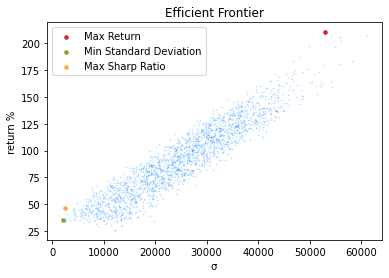

In [21]:
# Plot efficient frontier (last time)
show_frontier(ptf_return, ptf_std, max_return, min_std, sharp_r)

### Experiment: Optimal Weights VS Random Weights VS Nasdaq-100<a name='Exp2'></a>

In [23]:
'''
Optimal Weights Investment
'''
Capital = 1
weights = weights_mean
opt_variations = []

for i in range(len(test_data)):
    R_r = 0
    cnt = 0
    for stock_name in test_data.columns:
        R_r += weights[cnt] * test_data[stock_name][i]
        cnt += 1
    opt_variations.append(R_r)
    Capital *= (1 + R_r)

optimal_sr = sigmoid((np.mean(opt_variations) - (1 + rf)**(1/360) + 1)) / np.std([i for i in opt_variations])
optimal_cap = (Capital - 1) * 100

# len(test_data)
print('Trading Period: Month 10')
print('Optimal Investment Return: ' + str(round(optimal_cap, 3)) + ' %' )
print('Expected Annual Return(%): ', ((1 + np.mean(opt_variations))**242 - 1) * 100)
print('Expected Annual Vola(%): ', (1 + np.std(opt_variations))**242 - 1 )
print('Score: ', round(optimal_sr, 3))
np.std([i for i in opt_variations])

Trading Period: Month 10
Optimal Investment Return: 4.596 %
Expected Annual Return(%):  69.1400010544824
Expected Annual Vola(%):  5.91416036047147
Score:  62.301


0.008021969973123527

In [48]:
'''
Random weights investment
'''
# Set random weight
def random_weights(num,stock_list):
    weight=np.random.uniform(1,100,size=[num,len(stock_list)])
    for i in range(0,num):
        a_sum=0.0
        for j in range(0,len(stock_list)):
            a_sum+=weight[i][j]
        for k in range(0,len(stock_list)):
            weight[i][k]=round(float(weight[i][k]/a_sum),4)
    return weight  

# Simulate 1000 times
simulation_times = 1000
return_lst = []
sharp_ratio_lst = []

for i in tqdm(range(simulation_times)):
    weights = random_weights(1, [0.1 for i in range(10)]).squeeze()
    random_variations = [ ]
    capital = 1 # initial capital
    for i in range(len(test_data)):
        R_r = 0
        cnt = 0
        for stock_name in test_data.columns:
            R_r += weights[cnt] * test_data[stock_name][i]
            cnt += 1
        random_variations.append(R_r)
        capital *= (1 + R_r)
    return_lst.append( (capital - 1) * 100 )
    sharp_ratio_lst.append(sigmoid((np.mean(random_variations) - (1 + rf)**(1/360) + 1)) / np.std([ i for i in random_variations]))

print('Trading Days: ', len(test_data))
print('Random Invest Return: %.3f %% (%.3f)' %(np.mean(return_lst), np.std(return_lst)))
print('Score: %.3f (%.3f)' %(np.mean(sharp_ratio_lst), np.std(sharp_ratio_lst)))

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1918.76it/s]

Trading Days:  23
Random Invest Return: -1.571 % (1.864)
Score: 48.699 (5.920)


In [36]:
'''
Nasdaq-100 investment
'''
test_nasdaq = df_nasdaq_100['change_rate'][242:]

Capital = 1
weights = weights_mean
nasdaq_variations = [ ]

for i in range(len(test_nasdaq)):
    R_r = test_nasdaq.iloc[i]
    nasdaq_variations.append(R_r)
    Capital *= (1 + R_r)

optimal_sr = sigmoid((np.mean(nasdaq_variations) - (1 + rf)**(1/360) + 1)) / np.std([i for i in nasdaq_variations])
optimal_cap = (Capital - 1) * 100

print('Trading Days: ', len(test_nasdaq))
print('Nasdaq-100 Return: ' + str(round(optimal_cap, 3)) + ' %' )
print('Score: ', round(optimal_sr, 3))


Trading Days:  23
Nasdaq-100 Return: -1.307 %
Score:  42.756


### Plot Cumulative Return & Change Rate of Portfolios <a name='pltCR2'> </a>

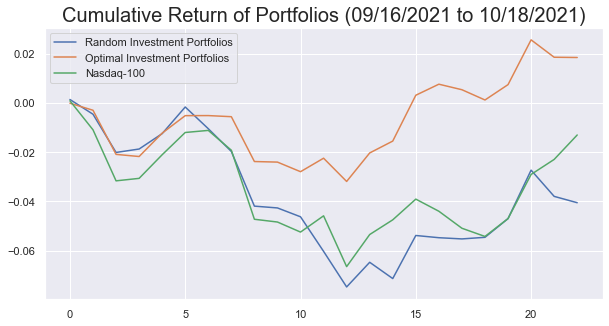

In [49]:
# Plot Time series of cumulative return
df_portfolios = pd.DataFrame({
    'Random Investment Portfolios': random_variations,
    'Optimal Investment Portfolios':opt_variations,
    'Nasdaq-100': nasdaq_variations
})

plt.figure(figsize=(10, 5))
for col in df_portfolios.columns:
    plt.plot((df_portfolios[col]+1).cumprod()-1, label=col)
    
plt.title('Cumulative Return of Portfolios (09/16/2021 to 10/18/2021)', fontsize=20)
plt.legend();

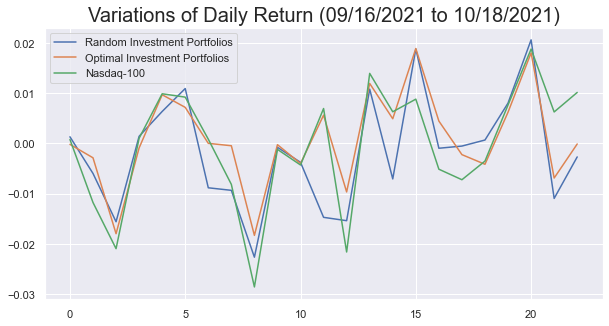

In [50]:
# Check the volatility of yield
sns.set()
plt.figure(figsize=(10, 5))

for col in df_portfolios.columns:
    plt.plot(df_portfolios[col], label=col)
plt.title('Variations of Daily Return (09/16/2021 to 10/18/2021)', fontsize=20)
plt.legend()